/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2933 - val_loss: 0.1756
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1639 - val_loss: 0.1392
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1450 - val_loss: 0.1302
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1240 - val_loss: 0.1244
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1207 - val_loss: 0.1169
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1182 - val_loss: 0.1129
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1118 - val_loss: 0.1081
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1095 - val_loss: 0.1066
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1078 - val_loss: 0.1063
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1064 - val_loss: 0.1071
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1183 - val_loss: 0.1060
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1123 - va

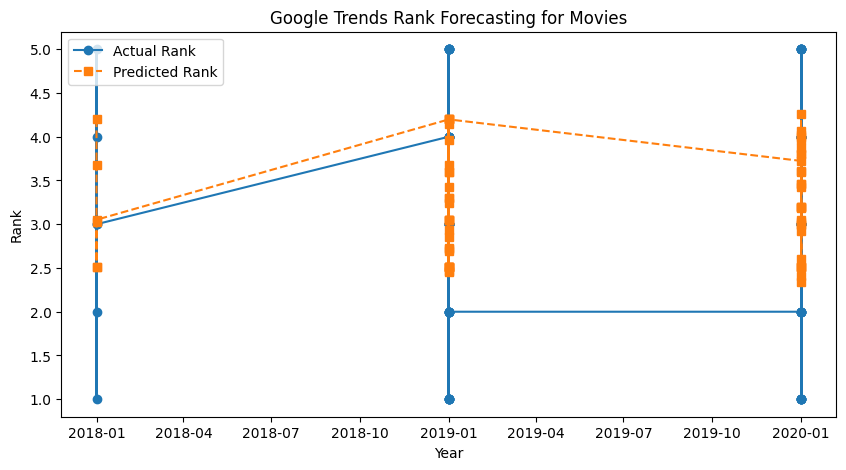

In [2]:
# Install TensorFlow if not installed
!pip install tensorflow --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/trends.csv")

# Convert 'year' to datetime format
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Select a specific category for forecasting
category = "Movies"  # Change this as needed
df_category = df[df['category'] == category]

# Sort by year and set as index
df_category = df_category.sort_values('year')
df_category.set_index('year', inplace=True)

# Normalize the rank values for better training
scaler = MinMaxScaler(feature_range=(0, 1))
df_category['rank_scaled'] = scaler.fit_transform(df_category[['rank']])

# Function to create a sliding window dataset
def create_dataset(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare the dataset
time_steps = 3
X, y = create_dataset(df_category['rank_scaled'].values, time_steps)

# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df_category.index[-len(y_test):], y_test_actual, label="Actual Rank", marker='o')
plt.plot(df_category.index[-len(y_test):], y_pred_actual, label="Predicted Rank", linestyle='dashed', marker='s')
plt.xlabel("Year")
plt.ylabel("Rank")
plt.title(f"Google Trends Rank Forecasting for {category}")
plt.legend()
plt.show()
